In [1]:
import numpy as np
import random
import pandas as pd
import boto3
import io
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import scipy
from scipy.sparse import csc_matrix, kron
from scipy.sparse.linalg import expm_multiply

In [2]:
def qp_eval(x, Q, b):
    return 0.5 * x @ Q @ x + b @ x

In [236]:
s3 = boto3.resource('s3')
bucket_name = "amazon-braket-wugroup-us-east-1"
bucket = s3.Bucket(bucket_name)

In [238]:
# Load simulation data
T_sim = [1e-3, 1e-2, 1e-1, 1, 2, 5, 10, 20, 50]
num_instances = 10

sim_data = np.empty((num_instances, len(T_sim)))
post_sim_data = np.empty((num_instances, len(T_sim)))

for instance in range(num_instances):
    # Load instance data from S3
    instance_filename = f"jiaqileng/qhd/QP-3d/instance_{instance}/instance_{instance}.npy"
    res = boto3.client('s3').get_object(Bucket=bucket_name, Key=instance_filename)
    bytes_ = io.BytesIO(res['Body'].read())
    Q = np.load(bytes_)
    b = np.load(bytes_)
    Q_c = np.load(bytes_)
    b_c = np.load(bytes_)
    
    # Load ground truth from S3
    gurobi_filename = f"jiaqileng/qhd/QP-3d/instance_{instance}/gurobi_solution_{instance}.npy"
    res = boto3.client('s3').get_object(Bucket=bucket_name, Key=gurobi_filename)
    bytes_ = io.BytesIO(res['Body'].read())
    x_min = np.load(bytes_)
    f_min = qp_eval(x_min, Q, b)
    
    counter = 0
    
    for tf in T_sim:
        # Load simulation data from S3
        simulation_filename = f"jiaqileng/qhd/QP-3d/instance_{instance}/advantage6_sim_rez8_T{tf}_distribution_{instance}.npy"
        res = boto3.client('s3').get_object(Bucket=bucket_name, Key=simulation_filename)
        bytes_ = io.BytesIO(res['Body'].read())
        expect_val = np.load(bytes_)
        sim_data[instance, counter] = expect_val-f_min
        
        # Load post simulation data from S3
        post_simulation_filename = f"jiaqileng/qhd/QP-3d/instance_{instance}/post_advantage6_sim_rez8_T{tf}_sample_{instance}.npy"
        res = boto3.client('s3').get_object(Bucket=bucket_name, Key=post_simulation_filename)
        bytes_ = io.BytesIO(res['Body'].read())
        post_sim_samples = np.load(bytes_)
        
        expect_val = 0
        for i in range(len(post_sim_samples)):
            post_x_sample = post_sim_samples[i]
            expect_val += (qp_eval(post_x_sample, Q, b)-f_min)/1000
        post_sim_data[instance, counter] = expect_val
       
        
        counter += 1

In [285]:
T_dwave = [1, 2, 5, 10, 20, 50]
num_instances = 10

dwave_data = np.empty((num_instances, len(T_dwave)))
post_dwave_data = np.empty((num_instances, len(T_dwave)))

for instance in range(num_instances):
    # Load instance data from S3
    instance_filename = f"jiaqileng/qhd/QP-3d/instance_{instance}/instance_{instance}.npy"
    res = boto3.client('s3').get_object(Bucket=bucket_name, Key=instance_filename)
    bytes_ = io.BytesIO(res['Body'].read())
    Q = np.load(bytes_)
    b = np.load(bytes_)
    Q_c = np.load(bytes_)
    b_c = np.load(bytes_)
    
    # Load ground truth from S3
    gurobi_filename = f"jiaqileng/qhd/QP-3d/instance_{instance}/gurobi_solution_{instance}.npy"
    res = boto3.client('s3').get_object(Bucket=bucket_name, Key=gurobi_filename)
    bytes_ = io.BytesIO(res['Body'].read())
    x_min = np.load(bytes_)
    f_min = qp_eval(x_min, Q, b)
    
    
    counter = 0
    for tf in T_dwave:
        # Load dwave data from S3
        dwave_sample_filename = f"jiaqileng/qhd/QP-3d/instance_{instance}/advantage6_qhd_rez8_T{tf}_sample_{instance}.npy"
        res = boto3.client('s3').get_object(Bucket=bucket_name, Key=dwave_sample_filename)
        bytes_ = io.BytesIO(res['Body'].read())
        dwave_samples = np.load(bytes_)
        num_occurrences = np.load(bytes_)
        
         
        expect_val = 0
        for i in range(len(num_occurrences)):
            x_sample = dwave_samples[i]
            expect_val += (qp_eval(x_sample, Q, b)-f_min)*num_occurrences[i]/1000
        dwave_data[instance, counter] = expect_val
        
         # Load post-processed data from S3
        post_sample_filename = f"jiaqileng/qhd/QP-3d/instance_{instance}/post_advantage6_qhd_rez8_T{tf}_sample_{instance}.npy"
        res = boto3.client('s3').get_object(Bucket=bucket_name, Key=post_sample_filename)
        bytes_ = io.BytesIO(res['Body'].read())
        post_samples = np.load(bytes_)
        num_occurrences = np.load(bytes_)
        
        post_expect_val = 0
        for i in range(len(num_occurrences)):
            post_x_sample = post_samples[i]
            post_expect_val += (qp_eval(post_x_sample, Q, b)-f_min)*num_occurrences[i]/1000
        post_dwave_data[instance, counter] = post_expect_val

        counter += 1

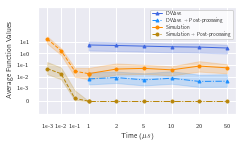

In [331]:
x_tick_1 = [0.5,1,1.5,2]
x_tick_2 = [2,3,4,5,6,7]
MARKERSIZE = 3
LINEWIDTH = 1

data_set = [dwave_data, post_dwave_data, sim_data, post_sim_data]
label_set = ["DWave", "DWave + Post-processing", "Simulation", "Simulation + Post-processing"]

color_set = [
    [0, 0.4470, 0.7410],
    [0.4940, 0.1840, 0.5560],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250], 
]

color_set = ['royalblue', 'dodgerblue', 'darkorange', 'darkgoldenrod']

fig, ax = plt.subplots(figsize=(9/2.54, 5/2.54))
plt.rcParams['text.usetex'] = True

for ii in range(4):
    data = data_set[ii]
    color = color_set[ii]
    label = label_set[ii]
    
    if label in ["DWave + Post-processing", "Simulation + Post-processing"]:
        linestyle = 'dashdot'
    else:
        linestyle = 'solid'
        
    if label in ["DWave", "DWave + Post-processing"]:
        marker = '^'
        T = x_tick_dw
    else:
        marker = 'o'
        T = x_tick_sim
    
    mean_ = data.mean(0)
    std_ = data.std(0)
    
    if label in ["Simulation + Post-processing"]:
        mean_[-1] = mean_[-2]
        std_[-1] = std_[-2]
    
    if label in ["Simulation", "Simulation + Post-processing"]:
        ax.plot(x_tick_1, mean_[0:4], 
                linestyle='dashed', linewidth=LINEWIDTH, color=color, 
                marker=marker, markersize=MARKERSIZE)
        ax.fill_between(x_tick_1, np.maximum(mean_[0:4]-std_[0:4], mean_[0:4]/3.0), mean_[0:4] + std_[0:4], 
                        alpha=0.2, color=color)    
        mean_ = mean_[3:9]
        std_ = std_[3:9]
        
    
    ax.plot(x_tick_2, mean_, label=label, color=color, 
             linewidth=LINEWIDTH, linestyle=linestyle,
             marker=marker, markersize=MARKERSIZE)
    ax.fill_between(x_tick_2, np.maximum(mean_-std_/ratio, mean_/3.0), mean_ + std_/ratio, alpha=0.2, color=color)

sns.set_theme()
ax.set_yscale('symlog', linthresh=1e-3)
#ax.set_xscale('log')
ax.set_ylim(-1e-3, 1e4)
ax.set_xticks(x_tick_sim)
ax.set_yticks([0,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yticklabels([0,'1e-3','1e-2','1e-1','1e0','1e1'], fontsize=6)
ax.set_xticklabels(['1e-3','1e-2','1e-1','1','2','5','10','20','50'], fontsize=6)
ax.set_xlabel('Time'+ r' ($\mu s$)', fontsize=7)
ax.set_ylabel('Average Function Values', fontsize=7)
plt.legend(loc='upper right', facecolor='white', bbox_to_anchor=(0.5, 0.85, 0.5, 0.15), fontsize=5)
#plt.savefig('DWave_vs_IdealQIM.svg')